In [1]:
import numpy as np
import ROOT as r
import sys,math,array,os
import matplotlib.pyplot as plt
r.gROOT.Macro(os.path.expanduser('~/.rootlogon_nystyle.C'))

Welcome to JupyROOT 6.20/02


0

# load bunch of numpy arrays

In [2]:
sigaeloss_bb  = np.load('./data/sigaeloss_bb1.npy')
sigaeloss_bkg = np.load('./data/sigaeloss_bkg.npy')
mass_bb       = np.load('./data/mass_bb1.npy')
mass_bkg      = np.load('./data/mass_bkg.npy')
bkgaeloss_bb  = np.load('./data/bkgaeloss_bb1.npy')
bkgaeloss_bkg = np.load('./data/bkgaeloss_bkg.npy')

In [3]:
############### DEFAULT CUT ##############
sigae_wp = .65
bkgae_wp = 2

In [4]:
index_bb = np.where((bkgaeloss_bb>bkgae_wp)&(sigaeloss_bb<sigae_wp))[0]
index_bkg = np.where((bkgaeloss_bkg>bkgae_wp)&(sigaeloss_bkg<sigae_wp))[0]

print(index_bb.shape[0])
print(index_bkg.shape[0])

2004
1903


In [5]:
bins = np.linspace(1000,8000,71,dtype=np.int16)
print(bins)

[1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300
 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700
 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100
 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500
 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900
 8000]


Text(0.5, 1.0, '$m_{JJ}$ without SF')

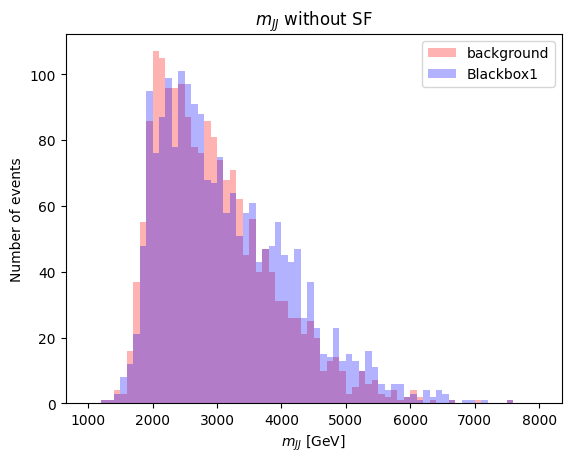

In [6]:
#### Without Scalefactor
#PLOT FOR BLACK BOX 1 with REALNVP
plt.style.use('default')
bins = np.linspace(1000,8000,71)
bkg_hist = plt.hist(mass_bkg[index_bkg],bins=bins,alpha=0.3,color='r',label='background');
obs_hist = plt.hist(mass_bb[index_bb],bins=bins,alpha=0.3,color='b',label='Blackbox1');
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
plt.legend(loc='upper right')
plt.title('$m_{JJ}$ without SF')
#plt.axvline(x=38238
#plt.savefig("/data/t3home000/spark/LHCOlympics/plots/NEW_BB3_mjj_massratios_noscalefactor_1dot8_0dot5.png")
# plt.savefig("AnalysisBB2/bkgAEcut_mjj_noscalefactor.png")

# Do a parametric fit to data

In [7]:
# Observable
mjj = r.RooRealVar("mjj","m_{JJ} [GeV]", 2200,8000)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [8]:
# Parameters
sigmean  = r.RooRealVar("sigmean" , "X_{BB} mass" ,  4000, 3000, 7000)
sigwidth = r.RooRealVar("sigwidth", "X_{BB} width",  400, 10, 2000) 

In [9]:
# Build Gaussian PDF
signalModel = r.RooGaussian("signal","signal PDF",mjj,sigmean,sigwidth)

In [10]:
print(mjj)

RooRealVar::mjj = 5100  L(2200 - 8000) 



In [11]:
# Build Background PDF with ATLAS Dijet background fit
#p0 = r.RooRealVar("p0","p0",100,-2000,2000)
#p1 = r.RooRealVar("p1","p1",1,-2000,100)
#p2 = r.RooRealVar("p2","p2",1,-2000,100)
#p3 = r.RooRealVar("p3","p3",1,-2000,100)
#background = r.RooGenericPdf("background","background","(pow(1-mjj,p1))/pow(mjj,(p2+p3*log(mjj)))",r.RooArgList(mjj,p1,p2,p3))

In [12]:
# Build Background PDF with ATLAS Dijet background fit
p0 = r.RooRealVar("p0","p0",-0.02,-100,100)
p1 = r.RooRealVar("p1","p1",0.5,-100,100)
p2 = r.RooRealVar("p2","p2",0.1,-100,100)
p3 = r.RooRealVar("p3","p3",0.1,-100,100)
#p4 = r.RooRealVar("p4","p4",0.1,-2000,2000)
background = r.RooPolynomial("background","background",mjj,r.RooArgList(p0,p1,p2,p3))

In [13]:
# Construct Signal + Background PDFs 
nsig = r.RooRealVar("nsig","#signal events",10,0.,10000)
nbkg = r.RooRealVar("nbkg","#background events",800,0.,10000)
model = r.RooAddPdf("model","g+b",r.RooArgList(signalModel,background),r.RooArgList(nsig,nbkg))

In [14]:
#prepare data
roothist_obs = r.TH1F('data_obs','data_obs',70,1000,8000)
roothist_bkg = r.TH1F('purebkg','purebkg',70,1000,8000)
for i in range(0,70):
    roothist_obs.SetBinContent(i+1,obs_hist[0][i])
    roothist_bkg.SetBinContent(i+1,bkg_hist[0][i])


In [15]:
data = r.RooDataHist("data","data",r.RooArgList(mjj),roothist_obs)
bkg = r.RooDataHist("bkg","bkg",r.RooArgList(mjj),roothist_bkg)

In [16]:
background.fitTo(bkg)

<ROOT.RooFitResult object at 0x(nil)>

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 p0          -2.00000e-02  2.00000e+01   -1.00000e+02  1.00000e+02
     2 p1           5.00000e-01  2.00000e+01   -1.00000e+02  1.00000e+02
     3 p2           1.00000e-01  2.00000e+01   -1.00000e+02  1.00000e+02
     4 p3           1.00000e-01  2.00000e+01   -1.00000e+02  1.00000e+02
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIGRAD        2000           1
 **********
 FIRST CALL TO USER FUNCTION AT NEW START POINT, WITH IFLAG=4.
 START MIGRAD MINIMIZATION.  STRATEGY  1.  CONVERGENCE WHEN EDM .LT. 1.00e-03
[#0

In [17]:
mjjframe = mjj.frame()

In [ ]:
data.plotOn(mjjframe)

In [ ]:
bkg.plotOn(mjjframe)

In [ ]:
c = r.TCanvas("myCanvasName","The Canvas Title",800,600)
#model.plotOn(mjjframe, r.RooFit.Components("background"), r.RooFit.LineStyle(r.kDashed))
mjjframe.Draw()

c.Draw()

# Start Generating Shapes for the Fit

In [ ]:
function_gaus = r.TF1("mygaus","TMath::Gaus(x,3823,200)",1000,8000)
roothist_sig = r.TH1F('signal','signal',70,1000,8000)
roothist_sig.FillRandom("mygaus",10000)

In [ ]:
lDM = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
x    = rt.RooRealVar   ("x" ,"x", 0.0   ,1000  ,8000)
mean = rt.RooRealVar("mean",'mean',3823,1000,8000)
sigma = rt.RooRealVar("sigma",'sigma',200,0,500)

In [ ]:
iDataHist = rt.RooDataHist("inputdata","inputdata",rt.RooArgList(x),roothist_sig)

In [ ]:
lDM     = rt.RooRealVar("Xshift","Xshift", 1.,0.,2.)
lVar    = iDataHist.createHistogram("x").GetMean()
lInt    = iDataHist.createHistogram("x").Integral()

In [ ]:
iVar = rt.RooRealVar("x","x",3600,1000,8000)
lShift  = rt.RooFormulaVar("Xsmear","("+iVar.GetName()+"-"+str(lVar)+")/Xshift+"+str(lVar),rt.RooArgList(iVar,lDM))  